# Lektion 16 - Data Quality

## Syfte och mål
Real-world data is inherently flawed. This lesson focuses on making data robust and reliable. You will learn systematic methods for handling dirty data: removing duplicates, employing sophisticated missing value strategies, and statistically identifying and treating extreme values (outliers).

## Learning Objectives
- Identify and handle duplicate records using Pandas
- Apply different strategies for missing value imputation
- Use statistical methods (IQR) to identify outliers
- Implement outlier treatment strategies (dropping, capping, transformation)
- Build a comprehensive data quality audit pipeline


## Pre-class Reading

### Korta läshänvisningar:
- **Handling Duplicates**: [Handle Duplicate Values in Pandas](https://www.programiz.com/python-programming/pandas/handle-duplicate-values)
- **The IQR Method**: [Interquartile Range to Detect Outliers](https://www.geeksforgeeks.org/machine-learning/interquartile-range-to-detect-outliers-in-data/)

### Fördjupning / Längre läshänvisningar:
- **Advanced Imputation**: [Techniques to Pandas Impute Missing Values](https://medium.com/@heyamit10/techniques-to-pandas-impute-missing-values-993f64ad2132)
- **Outlier Treatment Strategies**: [Quick Guide to Outlier Treatment](https://medium.com/@bhatshrinath41/quick-guide-to-outlier-treatment-ada01f8cfc5)

### Videos:
- Identifying and Handling Outliers: Visual demonstration of boxplot methods for finding outliers
- Comprehensive Data Cleaning: Complete cleaning pipeline from checking nulls to handling inconsistent text formatting


## Classroom Activities (Hands-on Lab)

### Aktivitet 1: Discussion - Trusting the Data (15 min)
Start with a discussion on the costs of poor data quality in an AI context (e.g., a model trained on faulty data performs poorly in production).

**Questions:**
- "Why is simply dropping every row with a missing value often a bad strategy?"
- "If you are analyzing a feature like Income, and you find outliers, what is one reason you might choose to cap them instead of removing them?"

### Aktivitet 2: Lab - Duplicates, Imputation, and Outlier Treatment (60 min)
Students will work with a deliberately messy dataset to implement data quality checks.


In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
# 1. Create Sample Data with Missing Values and Outliers
data = {'Category': ['A', "A", 'A', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'A'],
        'Value': [10, 10, 12, 100, 15, 12, 11, 250, 8, 9, 13],  # 100 and 250 are outliers
        'City': ['NY',"NY" ,'NY', np.nan, 'London', 'London', 'NY', 'Paris', 'NY', 'London', 'NY'],
        'Score': [85, 85, 92, np.nan, 78, 88, 95, 45, 82, 90, 87],
        'Name': ['John',"John" , 'Jane', 'Bob', 'Alice', 'Charlie', 'John', 'David', 'Eve', 'Frank', 'Grace']}

df_messy = pd.DataFrame(data)

print("Original Messy Dataset:")
print(df_messy)
print(f"\nDataset shape: {df_messy.shape}")
print(f"\nData types:\n{df_messy.dtypes}")


Original Messy Dataset:
   Category  Value    City  Score     Name
0         A     10      NY   85.0     John
1         A     10      NY   85.0     John
2         A     12      NY   92.0     Jane
3         B    100     NaN    NaN      Bob
4         A     15  London   78.0    Alice
5         B     12  London   88.0  Charlie
6         B     11      NY   95.0     John
7         A    250   Paris   45.0    David
8         A      8      NY   82.0      Eve
9         B      9  London   90.0    Frank
10        A     13      NY   87.0    Grace

Dataset shape: (11, 5)

Data types:
Category     object
Value         int64
City         object
Score       float64
Name         object
dtype: object


### Step 1: Data Quality Assessment


In [44]:
# With isnull()-method, we can check for missing values in the DataFrame
# What we get is a dataframe of the same shape as the DataFrame we're checking
# with True/False on each cell, depending on whether the value is missing or not
# NaN or None 
df_messy.isnull()


,Category,Value,City,Score,Name
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,True,True,False
4,False,False,False,False,False
5,False,False,False,False,False
6,False,False,False,False,False
7,False,False,False,False,False
8,False,False,False,False,False
9,False,False,False,False,False


In [45]:
# We typically use isnull() together with sum() to get a count of missing values per column
df_messy.isna().sum()

Category    0
Value       0
City        1
Score       1
Name        0
dtype: int64

In [46]:
# GENERAL TIP: Pandas has many methods
# Explore them! 

df_messy.duplicated()


0     False
1      True
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
dtype: bool

In [47]:
# Check for missing values
print("Missing Values Summary:")
print(df_messy.isnull().sum())
print(f"\nTotal missing values: {df_messy.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {df_messy.duplicated().sum()}")
print(f"Duplicate rows (considering all columns): {df_messy.duplicated().sum()}")

# Check for duplicates in specific columns
print(f"Duplicate names: {df_messy['Name'].duplicated().sum()}")

# Basic statistics for numerical columns
print(f"\nNumerical columns statistics:")
print(df_messy.describe())


Missing Values Summary:
Category    0
Value       0
City        1
Score       1
Name        0
dtype: int64

Total missing values: 2

Duplicate rows: 1
Duplicate rows (considering all columns): 1
Duplicate names: 2

Numerical columns statistics:
            Value      Score
count   11.000000  10.000000
mean    40.909091  82.700000
std     74.322883  14.111067
min      8.000000  45.000000
25%     10.000000  82.750000
50%     12.000000  86.000000
75%     14.000000  89.500000
max    250.000000  95.000000


### Step 2: Handling Missing Values


In [48]:
# It's often useful to keep a dataframe of the original data
# When processing we make copies

df_cleaned = df_messy.copy()

df_cleaned

,Category,Value,City,Score,Name
0,A,10,NY,85.0,John
1,A,10,NY,85.0,John
2,A,12,NY,92.0,Jane
3,B,100,NaN,NaN,Bob
4,A,15,London,78.0,Alice
5,B,12,London,88.0,Charlie
6,B,11,NY,95.0,John
7,A,250,Paris,45.0,David
8,A,8,NY,82.0,Eve
9,B,9,London,90.0,Frank


In [49]:
# We can handle missing values by various methods
# One is to fill them with the mean/median/mode of the column
# Another is to drop rows/columns with missing values
# A third is to use interpolation or other advanced methods including ML

df_cleaned["City"] = df_cleaned["City"].fillna(df_cleaned["City"].mode()[0])
df_cleaned

,Category,Value,City,Score,Name
0,A,10,NY,85.0,John
1,A,10,NY,85.0,John
2,A,12,NY,92.0,Jane
3,B,100,NY,NaN,Bob
4,A,15,London,78.0,Alice
5,B,12,London,88.0,Charlie
6,B,11,NY,95.0,John
7,A,250,Paris,45.0,David
8,A,8,NY,82.0,Eve
9,B,9,London,90.0,Frank


In [50]:
df_cleaned["Score"] = df_cleaned["Score"].fillna(df_cleaned["Score"].mean())
df_cleaned

,Category,Value,City,Score,Name
0,A,10,NY,85.0,John
1,A,10,NY,85.0,John
2,A,12,NY,92.0,Jane
3,B,100,NY,82.7,Bob
4,A,15,London,78.0,Alice
5,B,12,London,88.0,Charlie
6,B,11,NY,95.0,John
7,A,250,Paris,45.0,David
8,A,8,NY,82.0,Eve
9,B,9,London,90.0,Frank


In [51]:
df_cleaned['City'].mode()

0    NY
Name: City, dtype: object

In [52]:
df_cleaned["Score"].mean()

np.float64(82.7)

In [53]:
df_cleaned["Score"].median()    

np.float64(85.0)

In [54]:
# 2. Imputation (Mode for Categorical, Median for Outlier-Prone Numeric)
df_cleaned = df_messy.copy()

# For categorical variables, use mode
df_cleaned['City'] = df_cleaned['City'].fillna(df_cleaned['City'].mode()[0])

# For numerical variables, use median (more robust to outliers than mean)
df_cleaned['Score'] = df_cleaned['Score'].fillna(df_cleaned['Score'].median())

print("After Imputing Missing Values:")
print(df_cleaned)
print(f"\nMissing values after imputation: {df_cleaned.isnull().sum().sum()}")


After Imputing Missing Values:
   Category  Value    City  Score     Name
0         A     10      NY   85.0     John
1         A     10      NY   85.0     John
2         A     12      NY   92.0     Jane
3         B    100      NY   86.0      Bob
4         A     15  London   78.0    Alice
5         B     12  London   88.0  Charlie
6         B     11      NY   95.0     John
7         A    250   Paris   45.0    David
8         A      8      NY   82.0      Eve
9         B      9  London   90.0    Frank
10        A     13      NY   87.0    Grace

Missing values after imputation: 0


Step 2.5 drop duplicates
===

In [65]:
df_cleaned

,Category,Value,City,Score,Name
0,A,10,NY,85.0,John
1,A,10,NY,85.0,John
2,A,12,NY,92.0,Jane
3,B,100,NY,86.0,Bob
4,A,15,London,78.0,Alice
5,B,12,London,88.0,Charlie
6,B,11,NY,95.0,John
7,A,250,Paris,45.0,David
8,A,8,NY,82.0,Eve
9,B,9,London,90.0,Frank


In [66]:
# Identify duplicate rows
duplicates = df_cleaned.duplicated()
print(f"Duplicate rows identified:\n{df_cleaned[duplicates]}")

Duplicate rows identified:
  Category  Value City  Score  Name
1        A     10   NY   85.0  John


In [55]:
# Drop duplicates
df_dropped = df_cleaned.copy()
df_dropped = df_dropped.drop_duplicates()

In [56]:
df_dropped

,Category,Value,City,Score,Name
0,A,10,NY,85.0,John
2,A,12,NY,92.0,Jane
3,B,100,NY,86.0,Bob
4,A,15,London,78.0,Alice
5,B,12,London,88.0,Charlie
6,B,11,NY,95.0,John
7,A,250,Paris,45.0,David
8,A,8,NY,82.0,Eve
9,B,9,London,90.0,Frank
10,A,13,NY,87.0,Grace


### Step 3: Outlier Detection and Treatment


In [57]:
# 3. Outlier Detection using IQR Method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in Value column
outliers, lower_bound, upper_bound = detect_outliers_iqr(df_cleaned, 'Value')

print(f"Outlier Detection for 'Value' column:")
print(f"Q1: {df_cleaned['Value'].quantile(0.25):.2f}")
print(f"Q3: {df_cleaned['Value'].quantile(0.75):.2f}")
print(f"IQR: {df_cleaned['Value'].quantile(0.75) - df_cleaned['Value'].quantile(0.25):.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"\nOutliers found: {len(outliers)}")
print(outliers[['Name', 'Value']])


Outlier Detection for 'Value' column:
Q1: 10.00
Q3: 14.00
IQR: 4.00
Lower bound: 4.00
Upper bound: 20.00

Outliers found: 2
    Name  Value
3    Bob    100
7  David    250


In [58]:
# New treatment, means new copy

In [59]:
df_final = df_dropped.copy()
df_final

,Category,Value,City,Score,Name
0,A,10,NY,85.0,John
2,A,12,NY,92.0,Jane
3,B,100,NY,86.0,Bob
4,A,15,London,78.0,Alice
5,B,12,London,88.0,Charlie
6,B,11,NY,95.0,John
7,A,250,Paris,45.0,David
8,A,8,NY,82.0,Eve
9,B,9,London,90.0,Frank
10,A,13,NY,87.0,Grace


In [60]:
# using the below np.where approach to cap the outliers

df_final['Value'] = np.where(df_final['Value'] > upper_bound, upper_bound, df_final['Value'])
df_final['Value'] = np.where(df_final['Value'] < lower_bound, lower_bound, df_final['Value'])

df_final

,Category,Value,City,Score,Name
0,A,10.0,NY,85.0,John
2,A,12.0,NY,92.0,Jane
3,B,20.0,NY,86.0,Bob
4,A,15.0,London,78.0,Alice
5,B,12.0,London,88.0,Charlie
6,B,11.0,NY,95.0,John
7,A,20.0,Paris,45.0,David
8,A,8.0,NY,82.0,Eve
9,B,9.0,London,90.0,Frank
10,A,13.0,NY,87.0,Grace


In [61]:
np.where(df_final['Value'] > upper_bound, upper_bound, df_final['Value'])

array([10., 12., 20., 15., 12., 11., 20.,  8.,  9., 13.])

In [62]:
# 4. Outlier Treatment: Capping (Winsorization)
df_final = df_cleaned.copy()

# Cap outliers to the calculated bounds
df_final['Value'] = np.where(df_final['Value'] > upper_bound, upper_bound, df_final['Value'])
df_final['Value'] = np.where(df_final['Value'] < lower_bound, lower_bound, df_final['Value'])

print("After Capping Outliers:")
print(df_final)
print(f"\nValue column statistics after capping:")
print(df_final['Value'].describe())


After Capping Outliers:
   Category  Value    City  Score     Name
0         A   10.0      NY   85.0     John
1         A   10.0      NY   85.0     John
2         A   12.0      NY   92.0     Jane
3         B   20.0      NY   86.0      Bob
4         A   15.0  London   78.0    Alice
5         B   12.0  London   88.0  Charlie
6         B   11.0      NY   95.0     John
7         A   20.0   Paris   45.0    David
8         A    8.0      NY   82.0      Eve
9         B    9.0  London   90.0    Frank
10        A   13.0      NY   87.0    Grace

Value column statistics after capping:
count    11.000000
mean     12.727273
std       4.076540
min       8.000000
25%      10.000000
50%      12.000000
75%      14.000000
max      20.000000
Name: Value, dtype: float64


### Step 4: Visualizing Data Quality Improvements


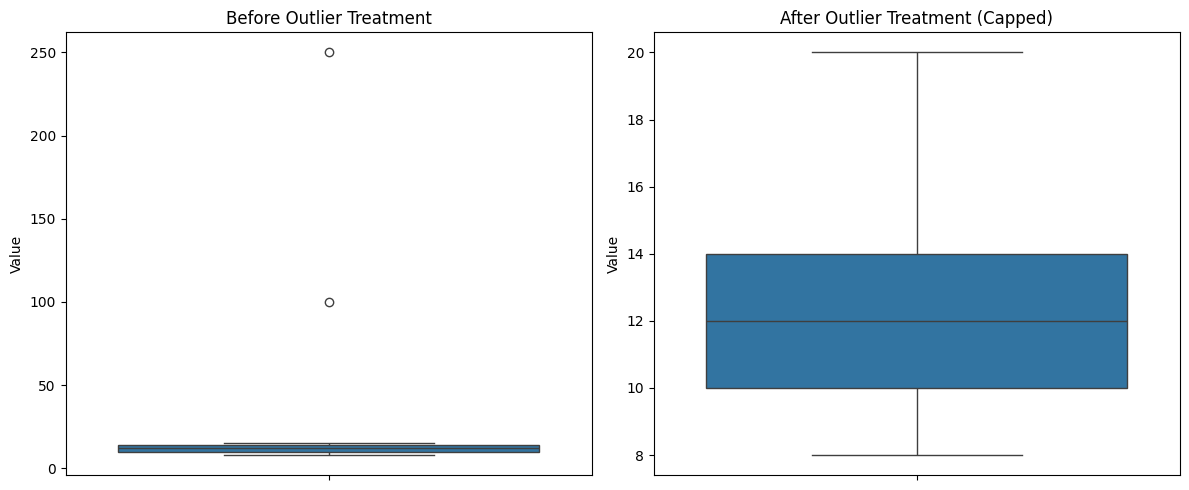

In [63]:
# Visualize the impact of outlier treatment
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before outlier treatment
sns.boxplot(data=df_cleaned, y='Value', ax=axes[0])
axes[0].set_title('Before Outlier Treatment')
axes[0].set_ylabel('Value')

# After outlier treatment
sns.boxplot(data=df_final, y='Value', ax=axes[1])
axes[1].set_title('After Outlier Treatment (Capped)')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()


### Step 5: Comprehensive Data Quality Report


In [64]:
# Generate a comprehensive data quality report
def data_quality_report(df, df_name):
    print(f"=== Data Quality Report for {df_name} ===")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
    
    print(f"\nMissing Values:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("✅ No missing values")
    else:
        print(missing[missing > 0])
    
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    
    print(f"\nNumerical Columns Summary:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        print(f"{col}: mean={df[col].mean():.2f}, std={df[col].std():.2f}, range=[{df[col].min():.2f}, {df[col].max():.2f}]")
    
    print(f"\nCategorical Columns Summary:")
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        print(f"{col}: {df[col].nunique()} unique values")

# Generate reports for original and cleaned data
data_quality_report(df_messy, "Original Messy Data")
print("\n" + "="*50 + "\n")
data_quality_report(df_final, "Cleaned Data")


=== Data Quality Report for Original Messy Data ===
Shape: (11, 5)
Memory usage: 2.20 KB

Missing Values:
City     1
Score    1
dtype: int64

Duplicate Rows: 1

Numerical Columns Summary:
Value: mean=40.91, std=74.32, range=[8.00, 250.00]
Score: mean=82.70, std=14.11, range=[45.00, 95.00]

Categorical Columns Summary:
Category: 2 unique values
City: 3 unique values
Name: 9 unique values


=== Data Quality Report for Cleaned Data ===
Shape: (11, 5)
Memory usage: 2.23 KB

Missing Values:
✅ No missing values

Duplicate Rows: 1

Numerical Columns Summary:
Value: mean=12.73, std=4.08, range=[8.00, 20.00]
Score: mean=83.00, std=13.42, range=[45.00, 95.00]

Categorical Columns Summary:
Category: 2 unique values
City: 3 unique values
Name: 9 unique values


### Aktivitet 3: Hands-on - Auditing a Dataset (30 min)
Students will apply the full data quality audit (isnull().sum(), duplicated(), boxplots) to their project dataset, document the issues they find, and justify the method they would use to fix each issue.

**Exercise:**
1. Load your project dataset
2. Run a comprehensive data quality audit
3. Document all issues found
4. Propose solutions for each issue
5. Implement the most appropriate solutions
6. Generate a final data quality report


### Aktivitet 4: Q&A and Moving to Statistics (15 min)
Discuss how cleaning the data (L16) and engineering the features (L15) directly leads to more trustworthy statistical and analytical results (L17).


## Assignment
**Complete the L16_assignment.py** - This assignment provides hands-on practice with data quality using a deliberately messy sales dataset, including:
- Comprehensive data quality assessment
- Missing value analysis and imputation strategies
- Duplicate detection and handling
- Outlier detection and treatment using IQR method
- Data consistency and validation
- Data quality monitoring functions
- Comprehensive reporting and documentation


## Key Takeaways

1. **Data Quality is Critical**: Poor data quality leads to poor model performance and unreliable insights
2. **Missing Value Strategies**:
   - Mode for categorical variables
   - Median for numerical variables (more robust than mean)
   - Forward/backward fill for time series data
3. **Outlier Detection**: Use IQR method for statistical outlier identification
4. **Outlier Treatment Options**:
   - **Capping (Winsorization)**: Preserve data points while reducing extreme values
   - **Dropping**: Remove outliers entirely (use with caution)
   - **Transformation**: Apply log or other transformations
5. **Systematic Approach**: Always audit, document, and validate data quality improvements

## Best Practices

- **Document Everything**: Keep track of all data quality issues and solutions
- **Validate Impact**: Check how cleaning affects your analysis results
- **Domain Knowledge**: Consider business context when handling outliers
- **Automate When Possible**: Create reusable functions for common cleaning tasks
- **Test on Holdout**: Validate cleaning decisions on unseen data

## Common Pitfalls

- **Over-cleaning**: Don't remove too much data
- **Under-cleaning**: Don't ignore obvious data quality issues
- **Inconsistent Methods**: Use the same cleaning approach across similar datasets
- **Ignoring Context**: Consider the business meaning of outliers before removing them

## Next Steps
- Practice with your own datasets
- Build a reusable data quality pipeline
- Learn about advanced imputation techniques
- Move on to Lesson 17: Statistics and Hypothesis Testing
